# XGBOOST: Heart_disease

#Context:

The leading cause of death in the developed world is heart disease. Therefore there needs to be work done to help prevent the risks of of having a heart attack or stroke.

Content: Use this dataset to predict which patients are most likely to suffer from a heart disease in the near future using the features given.

Acknowledgement: This data comes from the University of California Irvine's Machine Learning Repository at https://archive.ics.uci.edu/ml/datasets/Heart+Disease.

source: https://kaggle.com/datasets/rishidamarla/heart-disease-prediction

## O.Importing Libraries

In [18]:
!pip install scikit-optimize

In [19]:
#importing the libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


import xgboost as xgb
from skopt import BayesSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score

## 1. Load the dataset:

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
# Specify the file path
file_path = '/content/drive/Shareddrives/MBD Term2 - Group 6/ML_Group Project/Heart_Disease_Prediction.csv'

# Load the data into a DataFrame
data = pd.read_csv(file_path)

In [22]:
data.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


In [23]:
data. info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      270 non-null    int64  
 1   Sex                      270 non-null    int64  
 2   Chest pain type          270 non-null    int64  
 3   BP                       270 non-null    int64  
 4   Cholesterol              270 non-null    int64  
 5   FBS over 120             270 non-null    int64  
 6   EKG results              270 non-null    int64  
 7   Max HR                   270 non-null    int64  
 8   Exercise angina          270 non-null    int64  
 9   ST depression            270 non-null    float64
 10  Slope of ST              270 non-null    int64  
 11  Number of vessels fluro  270 non-null    int64  
 12  Thallium                 270 non-null    int64  
 13  Heart Disease            270 non-null    object 
dtypes: float64(1), int64(12), 

## 2. Visualize data:

### 2.1: Looking into the target variable:

In [24]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

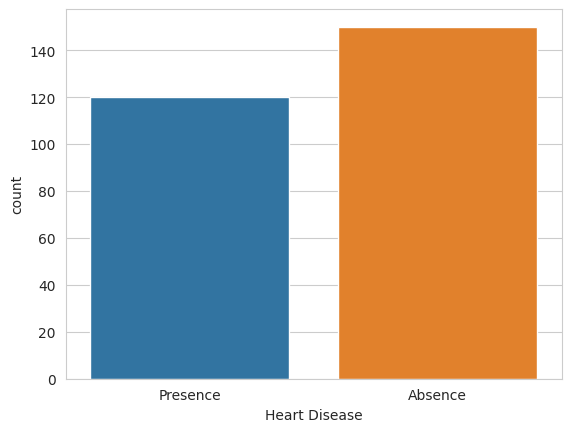

In [25]:
# Countplot to check class balance
sns.countplot(x='Heart Disease', data=data)
plt.show()

In [26]:
HeartDisease_counts = data['Heart Disease'].value_counts()
print(HeartDisease_counts)

Absence     150
Presence    120
Name: Heart Disease, dtype: int64


From this representation we can say that the dataset seems pretty balance, we will keep it as it is for now. However it is important to note that the data set is very small, we will have to take this aspect into consideration while running the model and interpreting the results.

### 2.2: Looking into the other variables:

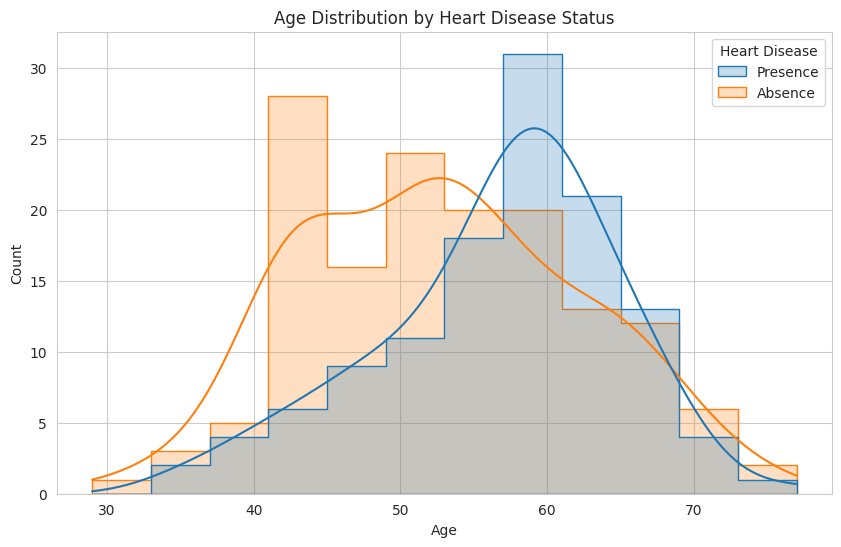

In [27]:
# Plot 1: Distribution of Age with respect to Heart Disease Presence
plt.figure(figsize=(10,6))
sns.histplot(data=data, x="Age", hue="Heart Disease", element="step", kde=True)
plt.title('Age Distribution by Heart Disease Status')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

This histogram with a kernel density estimate (KDE) overlay shows the distribution of patients' ages, segmented by the presence or absence of heart disease. The KDE helps to see the probability density of ages. If there is a particular age range with a high density of patients with heart disease compared to those without, as it is the case with teh pick before the 60s, it could suggest that age is a risk factor.

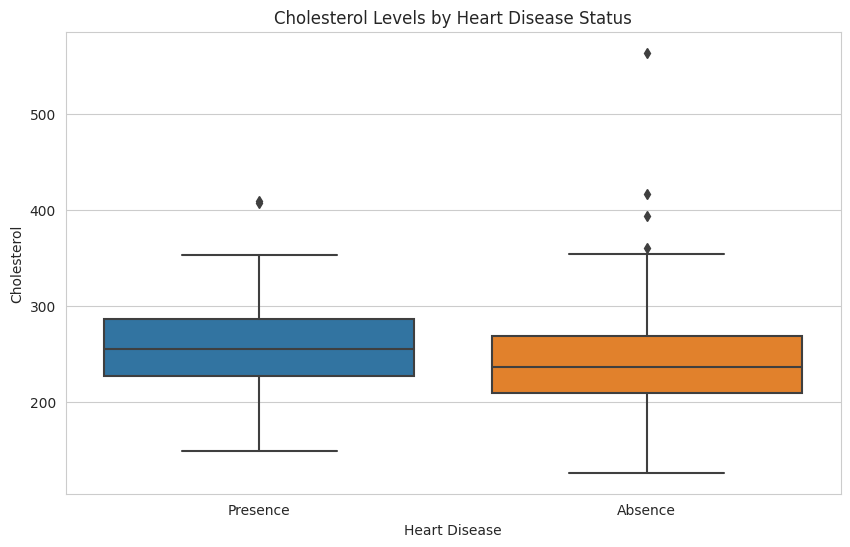

In [28]:
# Plot 3: Cholesterol Levels by Heart Disease Status
plt.figure(figsize=(10,6))
sns.boxplot(data=data, x="Heart Disease", y="Cholesterol")
plt.title('Cholesterol Levels by Heart Disease Status')
plt.xlabel('Heart Disease')
plt.ylabel('Cholesterol')
plt.show()

Suprisinglty this plot shows that cholesterol doesn't seem to be a very important variable, even though we can notice that when there is a heart disease the level of cholesterol is higher.

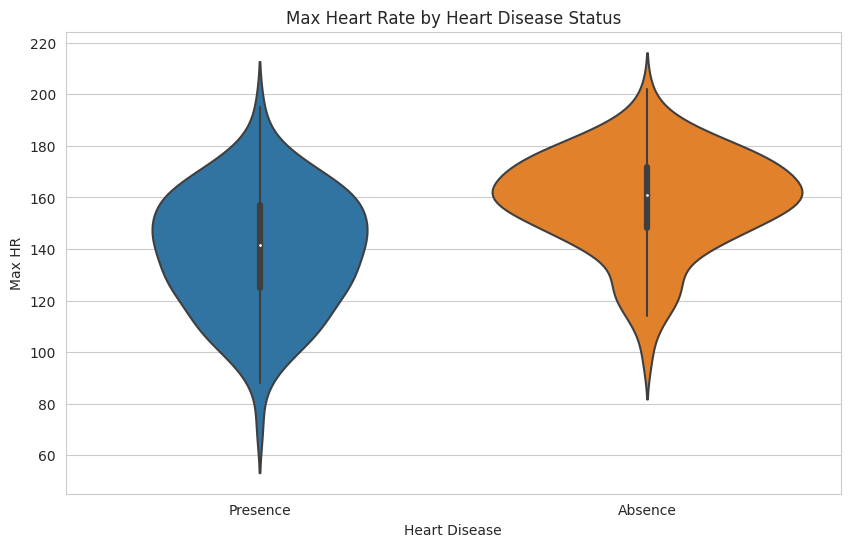

In [29]:
# Plot 4: Max Heart Rate by Heart Disease Status
plt.figure(figsize=(10,6))
sns.violinplot(data=data, x="Heart Disease", y="Max HR", split=True)
plt.title('Max Heart Rate by Heart Disease Status')
plt.xlabel('Heart Disease')
plt.ylabel('Max HR')
plt.show()

 This chart shows the distribution of maximum heart rates for patients with and without heart disease. The thicker sections of the violin plot represent a higher frequency of data points. The group that represents the absence of heart disease has a wider section at higher heart rates and this could indicate that those without heart disease tend to have higher maximum heart rates during exercise. Therefore, this also means that probably the maximum heart rate can be a useful feature in finding out heart disease.

## 3. EDA:

### 3.1: Checking for null values

In [30]:
# Check for missing values
data.isnull().sum()

Age                        0
Sex                        0
Chest pain type            0
BP                         0
Cholesterol                0
FBS over 120               0
EKG results                0
Max HR                     0
Exercise angina            0
ST depression              0
Slope of ST                0
Number of vessels fluro    0
Thallium                   0
Heart Disease              0
dtype: int64

### 3.2: Dealing with categorical variables:

In [31]:
data.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      270 non-null    int64  
 1   Sex                      270 non-null    int64  
 2   Chest pain type          270 non-null    int64  
 3   BP                       270 non-null    int64  
 4   Cholesterol              270 non-null    int64  
 5   FBS over 120             270 non-null    int64  
 6   EKG results              270 non-null    int64  
 7   Max HR                   270 non-null    int64  
 8   Exercise angina          270 non-null    int64  
 9   ST depression            270 non-null    float64
 10  Slope of ST              270 non-null    int64  
 11  Number of vessels fluro  270 non-null    int64  
 12  Thallium                 270 non-null    int64  
 13  Heart Disease            270 non-null    object 
dtypes: float64(1), int64(12), 

In [33]:
# Encode categorical variables (e.g., one-hot encoding)
data = pd.get_dummies(data, columns=['Chest pain type', 'Heart Disease'], drop_first=True)

#Note that for heart disease: 1=Presence

In [34]:
data.head()

,Age,Sex,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Chest pain type_2,Chest pain type_3,Chest pain type_4,Heart Disease_Presence
0,70,1,130,322,0,2,109,0,2.4,2,3,3,0,0,1,1
1,67,0,115,564,0,2,160,0,1.6,2,0,7,0,1,0,0
2,57,1,124,261,0,0,141,0,0.3,1,0,7,1,0,0,1
3,64,1,128,263,0,0,105,1,0.2,2,1,7,0,0,1,0
4,74,0,120,269,0,2,121,1,0.2,1,1,3,1,0,0,0


3.3 Correlation Matrix:

<Axes: >

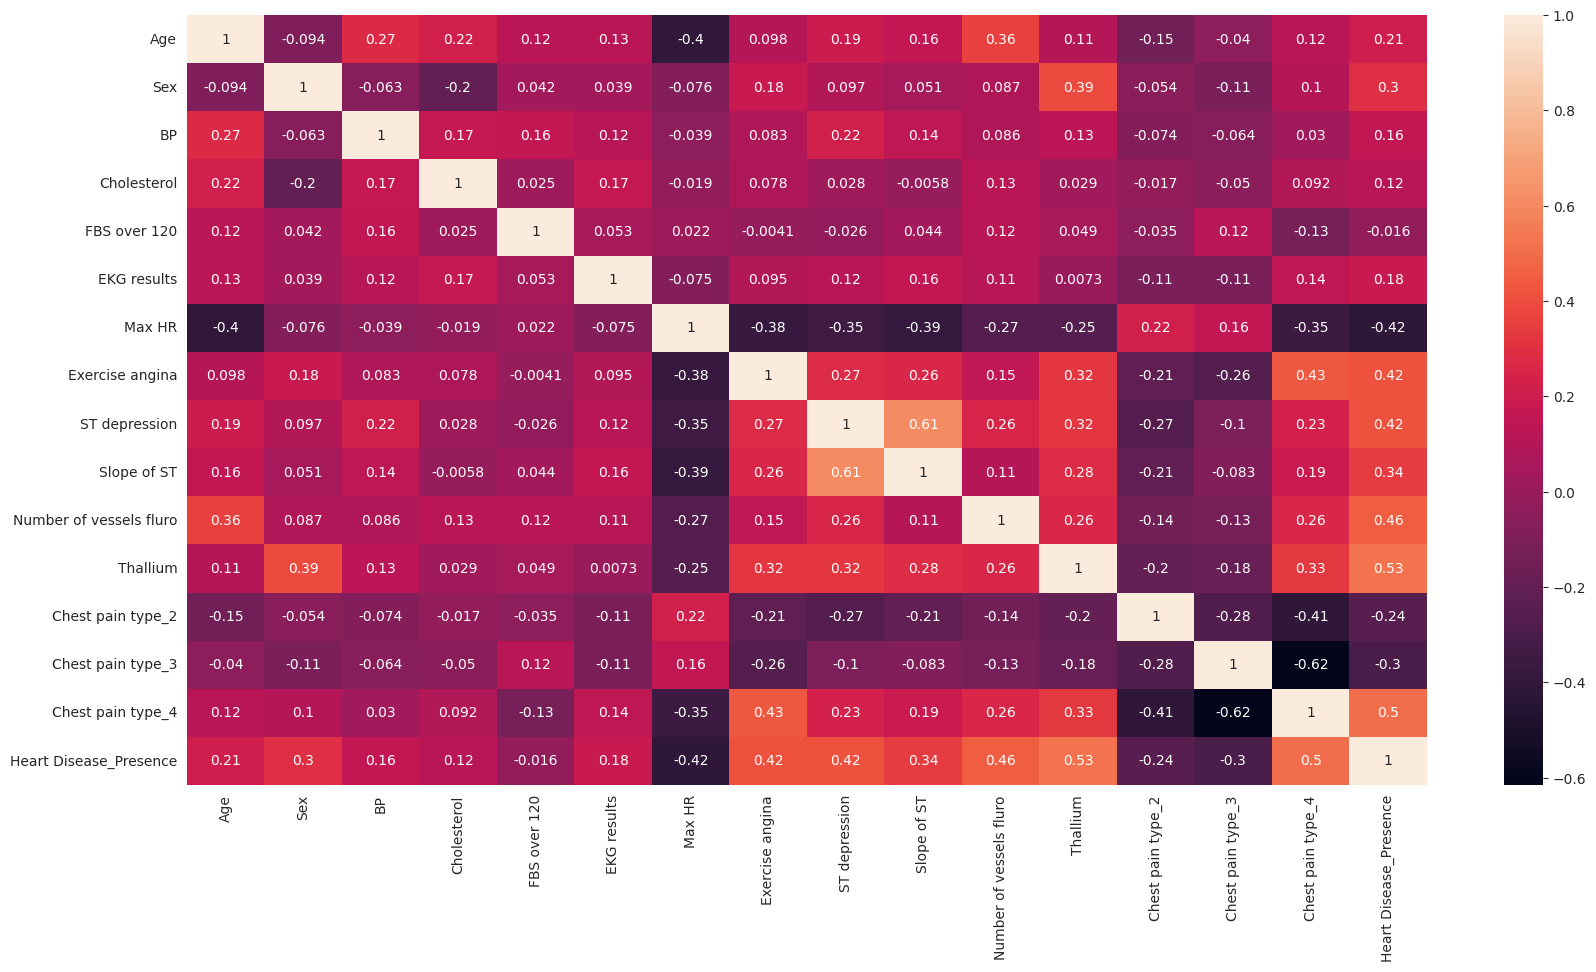

In [35]:
# Let's check the correlation between the variables
# Strong correlation between the mean radius and mean perimeter, mean area and mean primeter
plt.figure(figsize=(20,10))
sns.heatmap(data.corr(), annot=True)

From this correlation analysis, we can see that there are not any high correlation in between features. This means there is no need to remove features du to multicolinearity. Let's note high correlation is considered when it is superior to |0.66|.
However the correaltion matrix shows us that one variable is having a very low correlation to our target variable, *FBS over 120* with -0.016 of correlation (fasting blood sugar). However we belive it should be a relevant feature for detecting heart disease. Therefore we decided not to drop it.

## 4. Train/Test Split:

In [36]:
# Split data into features (X) and target (y)
X = data.drop('Heart Disease_Presence', axis=1)
y = data['Heart Disease_Presence']

In [37]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Creating an XGBoost Model with Hyperparameter tuning:

In [38]:
# Define the XGBoost model
xgb_model = xgb.XGBClassifier()

# Define the hyperparameter search space
param_space = {
    'n_estimators': (10, 1000),  # Number of boosting rounds
    'max_depth': (1, 10),
    'learning_rate': (0.01, 1.0, 'log-uniform'),
    'subsample': (0.5, 1.0, 'uniform'),
    'colsample_bytree': (0.5, 1.0, 'uniform'),
    'gamma': (0, 5, 'uniform'),
    'min_child_weight': (1, 10),
}

In [39]:
# Initialize Bayesian optimization for XGBoost
opt = BayesSearchCV(
    xgb_model,
    param_space,
    n_iter=32,
    cv=5,
    n_jobs=-1)

# Fit the model with Bayesian optimization
opt.fit(X_train, y_train)

BayesSearchCV(cv=5,
              estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None...
                                      missing=nan, monotone_constraints=None,
                                      multi_strategy=None, n_estimators=None,
                                      n_jobs=None, num_parallel_tree=None,
                                      random_state=None, ...),
              n_iter=32, n_jobs=-1,
              search_spaces={'colsample_bytree': (0.5, 1.0, 'uniform'),
                             'gamma': (0, 5, 'uniform'),
                             'learning_rate': (0.01, 1.0, 'log-uniform'),
                             'max_depth': (1, 10), 'min_child_weight': (1, 10),
                             'n_estimators': (10, 1000),
                             'subsample': (0.5, 1.0, 'uniform')})

In [40]:
# Get the best hyperparameters
best_params = opt.best_params_
best_score = opt.best_score_

print("Best Hyperparameters:", best_params)
print("Best Score (CV Accuracy):", best_score)

Best Hyperparameters: OrderedDict([('colsample_bytree', 0.7171751807396614), ('gamma', 5), ('learning_rate', 0.0122335964295913), ('max_depth', 9), ('min_child_weight', 1), ('n_estimators', 194), ('subsample', 0.7255150307678192)])
Best Score (CV Accuracy): 0.8338266384778011


In [41]:
# Make 'clf' an instance of the best model.
clf = opt.best_estimator_
clf

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7171751807396614, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=5, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.0122335964295913, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=194, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [42]:
# Display the score obtained by the best model.
opt.best_score_

0.8338266384778011

## 5. Make Predictions on the test dataset:

In [43]:
# Predict the classes of the samples in the test dataset using the best model.
y_test_pred = clf.predict(X_test)
y_test_pred.shape

(54,)

## 6. Construct the confusion matrix and print the classification report:

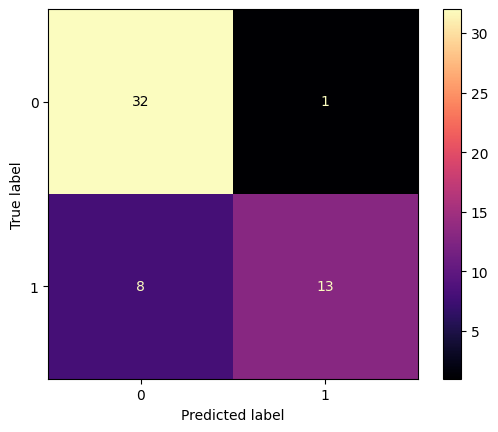

In [44]:
# Removing the seaborn visualization removes the white lines that come with it.
sns.reset_orig()

# Create a confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_test_pred,
    labels = clf.classes_,
    cmap = 'magma'
);

The confusion matrix provides a summary of the prediction results on a classification problem. The number of correct and incorrect predictions are summarized with count values and broken down by each class. From the above we can say that:
- True Negative (TN): The count of (0,0) = 32 indicates that 32 instances were correctly predicted as no heart disease (Absence).
- False Positive (FP): The count of (0,1) = 1 indicates that 1 instance was incorrectly predicted as having heart disease (Presence) when it actually did not (Absence).
- False Negative (FN): The count of (1,0) = 8 indicates that 8 instances were incorrectly predicted as no heart disease (Absence) when they actually did have it (Presence).
- True Positive (TP): The count of (1,1) = 13 indicates that 13 instances were correctly predicted as having heart disease (Presence).

The confusion matrix is crucial for understanding the model's performance beyond simple accuracy. It shows that the model is relatively conservative, predicting heart disease only when it's quite sure, which is why there are more false negatives (8) than false positives (1).

In [45]:
# Print the classification report with two target names
print(classification_report(y_test, y_test_pred, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.80      0.97      0.88        33
           1       0.93      0.62      0.74        21

    accuracy                           0.83        54
   macro avg       0.86      0.79      0.81        54
weighted avg       0.85      0.83      0.82        54



The classification report gives a detailed analysis of the performance of a classification algorithm. From the above we can say that:
- Precision (0): For the 'Absence' of heart disease, the precision is 0.80, meaning that when the model predicts no heart disease, it is correct 80% of the time.
- Recall (0): For the 'Absence' of heart disease, the recall is 0.97, indicating that the model identifies 97% of all actual instances of no heart disease correctly.
- F1-Score (0): The F1-score for 'Absence' is 0.88, which is a weighted average of precision and recall for the 'Absence' class, showing the model's balance between precision and recall for this class.
- Precision (1): For the 'Presence' of heart disease, the precision is 0.93, suggesting that when the model predicts heart disease, it is correct 93% of the time.
- Recall (1): The recall for 'Presence' is 0.62, indicating that the model identifies 62% of all actual instances of heart disease correctly.
- F1-Score (1): The F1-score for 'Presence' is 0.74, showing a balance between precision and recall for the 'Presence' class.
- Accuracy: Overall, the model has an accuracy of 0.83, meaning it correctly predicts the heart disease status 83% of the time across both classes.

**Conclusion:**
The classification report reflects a good model performance, especially considering the precision for predicting the presence of heart disease. However, the model could be improved in terms of recall for the 'Presence' class, as it's missing around 38% of the positive cases. This could be critical in a medical context, where failing to detect heart disease could have serious consequences. However this might also be related to the very small sample we had to train the model. Therefore, in order to improve the model a first step could be to gather more data on the specific topic in order to train the model on a bigger sample.

## 7. Save and export model:

In [48]:
import pickle

filename = 'xgboost_heart_disease_model.sav'
pickle.dump(opt,open(filename,'wb'))